In [15]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import glob
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d
from scipy.optimize import minimize
from scipy.fft import fft2, ifft2, fftshift
import matplotlib.patches as patches

In [ ]:
# I was using google colab to run with a TPU and getting my data from google drive. 
from google.colab import drive
drive.mount('/content/drive')

#### (I just tested that this code works, so I only trained the models for 10 epochs locally, the full training and results in my report are with 100 epochs which was trained on google colab with a TPU), so the images see are no

### Define functions

In [3]:
pixels = 32

def import_images(directory, resolution=(pixels, pixels), max_images=18, crop=0):
    images = []  # List to hold all the images
    image_files = sorted(glob.glob(os.path.join(directory, '*.png')))[:max_images]
    crop_size = crop
    for file_path in image_files:
        with Image.open(file_path) as img:
            img = Image.open(file_path)
            width, height = img.size
            img = img.crop((width*crop_size,
                              height*crop_size,
                              width*(1-crop_size),
                              height*(1-crop_size)))
            img = img.resize((pixels, pixels)).convert('L')
            images.append(np.asarray(img))

    return np.array(images)

# These are the lithography simulation 

def gaussian_psf(size, sigma):
    """Func for 2D Gaussian PSF"""
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    psf = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sigma))
    psf_out = psf / np.sum(psf)
    return psf_out

def optical_model(mask, psf):
    """Func to calc light intensity on the photoresist using PSF."""
    model_out = np.abs(convolve2d(mask, psf, mode='same')) ** 2
    return model_out


def photoresist_model(intensity, threshold, a_r):
    """Func to calc resist pattern based on the light intensity."""
    resist_out = 1 / (1 + np.exp(-a_r * (intensity - threshold)))
    return resist_out

#goal_layouts = import_images('/content/drive/MyDrive/sample_data_3/train_layouts',crop = 0.15)
#corrected_layouts = import_images('/content/drive/MyDrive/sample_data_3/train_masks',crop = 0)

goal_layouts = import_images('train_layouts',crop = 0.15)
corrected_layouts = import_images('train_masks',crop = 0)

### Test / train split of the data

In [4]:
# Normalize images
goal_layouts = goal_layouts.astype('float32') / 255.0
corrected_layouts = corrected_layouts.astype('float32') / 255.0

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(goal_layouts, corrected_layouts,
                                                    test_size=0.2, random_state=42)

### Simple Unet 

In [5]:
def unet(input_size=(32, 32, 1)):
    inputs = Input(input_size)

    # Contracting Path (Encoder)
    conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Bottom layer
    conv_bottom = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1)
    conv_bottom = Conv2D(16, (3, 3), activation='relu', padding='same')(conv_bottom)

    # Expanding Path (Decoder)
    up1 = UpSampling2D(size=(2, 2))(conv_bottom)
    merge1 = concatenate([conv1, up1], axis=3)
    conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')(merge1)
    conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv2)

    # Output layer
    conv_final = Conv2D(1, (1, 1), activation='sigmoid')(conv2)

    model = Model(inputs=inputs, outputs=conv_final)
    return model

### Train simple unet

In [7]:
%%time
model = unet(input_size=(32, 32, 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=1, validation_split=0.1)
#model.save('/path/to/save/model.h5')

y_pred = model.predict(X_test)

Epoch 1/10
12/12 [==============================] - 3s 106ms/step - loss: 0.6858 - accuracy: 0.7173 - val_loss: 0.6708 - val_accuracy: 0.8701
Epoch 2/10
12/12 [==============================] - 1s 65ms/step - loss: 0.6356 - accuracy: 0.8349 - val_loss: 0.5855 - val_accuracy: 0.8701
Epoch 3/10
12/12 [==============================] - 1s 60ms/step - loss: 0.5400 - accuracy: 0.8349 - val_loss: 0.4683 - val_accuracy: 0.8701
Epoch 4/10
12/12 [==============================] - 1s 60ms/step - loss: 0.4479 - accuracy: 0.8349 - val_loss: 0.3361 - val_accuracy: 0.8701
Epoch 5/10
12/12 [==============================] - 1s 68ms/step - loss: 0.3847 - accuracy: 0.8349 - val_loss: 0.2704 - val_accuracy: 0.8701
Epoch 6/10
12/12 [==============================] - 1s 63ms/step - loss: 0.3785 - accuracy: 0.8349 - val_loss: 0.3017 - val_accuracy: 0.8701
Epoch 7/10
12/12 [==============================] - 1s 61ms/step - loss: 0.3678 - accuracy: 0.8349 - val_loss: 0.2550 - val_accuracy: 0.8701
Epoch 8/10
1

### Deep Unet

In [8]:
def unet_deep(input_size=(32, 32, 1)):
    inputs = Input(input_size)

    # Contracting Path (Encoder)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.25)(pool2)

    # Middle layer
    conv_mid = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv_mid = BatchNormalization()(conv_mid)
    conv_mid = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_mid)
    conv_mid = BatchNormalization()(conv_mid)
    conv_mid = Dropout(0.5)(conv_mid)

    # Expanding Path (Decoder)
    up1 = UpSampling2D(size=(2, 2))(conv_mid)
    merge1 = concatenate([conv2, up1], axis=3)
    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge1)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)

    up2 = UpSampling2D(size=(2, 2))(conv3)
    merge2 = concatenate([conv1, up2], axis=3)
    conv4 = Conv2D(16, (3, 3), activation='relu', padding='same')(merge2)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    # Output layer
    conv_final = Conv2D(1, (1, 1), activation='sigmoid')(conv4)

    model = Model(inputs=inputs, outputs=conv_final)
    return model


### Train deep unet

In [9]:
%%time
model_2 = unet_deep(input_size=(pixels, pixels, 1))
model_2.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

history_2 = model_2.fit(X_train, y_train, epochs=10, batch_size=1, validation_split=0.1)

#model.save('/path/to/save/model.h5')

y_pred_2 = model_2.predict(X_test)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


12/12 [==============================] - 8s 373ms/step - loss: 0.9217 - accuracy: 0.4266 - val_loss: 0.6894 - val_accuracy: 0.6284
Epoch 2/10
12/12 [==============================] - 3s 292ms/step - loss: 0.8580 - accuracy: 0.4637 - val_loss: 0.6764 - val_accuracy: 0.7588
Epoch 3/10
12/12 [==============================] - 3s 289ms/step - loss: 0.8255 - accuracy: 0.4827 - val_loss: 0.6571 - val_accuracy: 0.8042
Epoch 4/10
12/12 [==============================] - 4s 297ms/step - loss: 0.8036 - accuracy: 0.5037 - val_loss: 0.6428 - val_accuracy: 0.8228
Epoch 5/10
12/12 [==============================] - 3s 286ms/step - loss: 0.7905 - accuracy: 0.5091 - val_loss: 0.6261 - val_accuracy: 0.8467
Epoch 6/10
12/12 [==============================] - 4s 296ms/step - loss: 0.7657 - accuracy: 0.5267 - val_loss: 0.6109 - val_accuracy: 0.8564
Epoch 7/10
12/12 [==============================] - 4s 315ms/step - loss: 0.7504 - accuracy: 0.5413 - val_loss: 0.5955 - val_accuracy: 0.8569
Epoch 8/10
12/12 

### Visualise the training histories of the two models

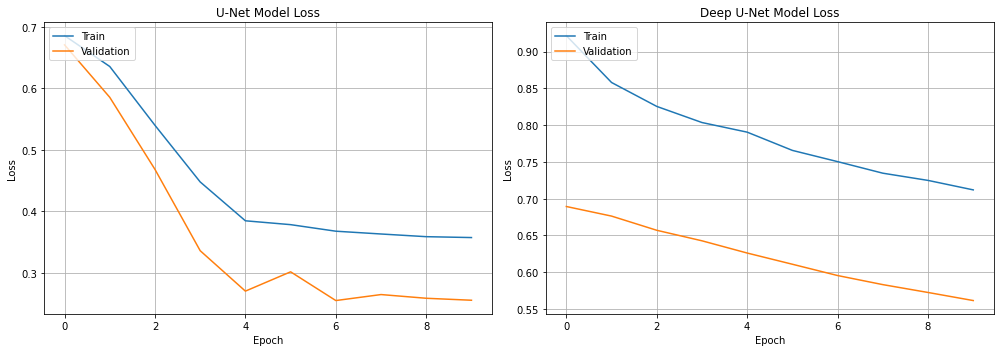

In [10]:
# Define the size of the overall figure
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('U-Net Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Deep U-Net Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Validation'], loc='upper left')

# Display the plots
plt.tight_layout()  # Adjust the layout
#plt.savefig('training.png',dpi=450)
plt.show()

### See how the model performs on complex unseen patterns

In [11]:
complex_layouts = import_images('random_pattern',crop=0).astype('float32') / 255.0
y_pred_complex = model.predict(complex_layouts)
y_pred_2_complex = model_2.predict(complex_layouts)

1/1 [==============================] - 1s 1s/step



 Next Prediction 



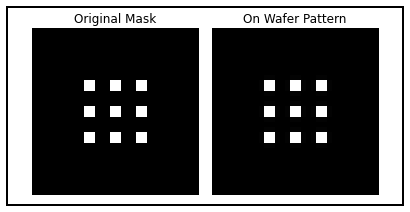

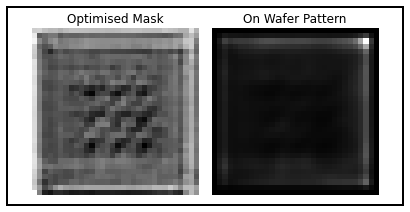


 Next Prediction 



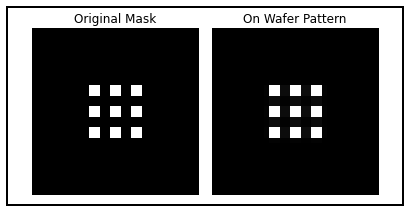

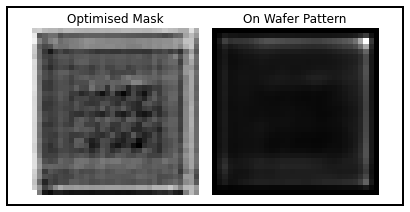

In [16]:
y_pred_complex2 = y_pred_complex[:,:,:,0]
y_pred_complex2 = y_pred_2_complex[:,:,:,0]
for i in range(2):
    print('\n Next Prediction \n')

    for mask, name in zip([complex_layouts[i], y_pred_complex2[i]], ['Original Mask', 'Optimised Mask']):
        fig = plt.figure(figsize=(5, 2.5))

        # Create two subplots with adjusted layout
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)

        psf = gaussian_psf(5, 1.2) 
        threshold = 0.25
        a_r = 50
        intensity = optical_model(mask, psf)
        resist_pattern = photoresist_model(intensity, threshold, a_r)

        ax1.imshow(mask, cmap='gray')
        ax1.set_title(name)
        ax1.axis('off')  
        ax2.imshow(resist_pattern, cmap='gray')
        ax2.set_title('On Wafer Pattern')
        ax2.axis('off') 

        plt.tight_layout(pad=0.1)  # Adjust the padding as needed
        border_width = 2  # Border width
        rect = patches.Rectangle((-0.05, -0.05), 1.1, 1.1, transform=fig.transFigure, 
                              clip_on=False, linewidth=border_width, edgecolor='k', facecolor='none')
        fig.patches.append(rect)  # Add the patch to the figure

        plt.show()

### Visualise and Interpret network layers 

In [18]:
img = load_img('random_pattern/test_31.png', target_size=(32, 32), color_mode='grayscale')
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0

layer_outputs = [layer.output for layer in model_2.layers[1:]]  # Exclude the input layer
activation_model = Model(inputs=model_2.input, outputs=layer_outputs)
activations = activation_model.predict(img_array)

1/1 [==============================] - 1s 793ms/step


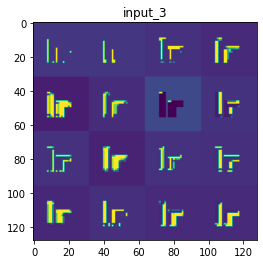

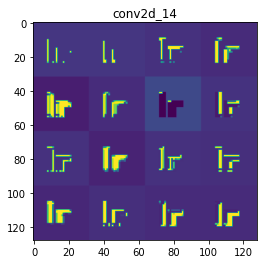

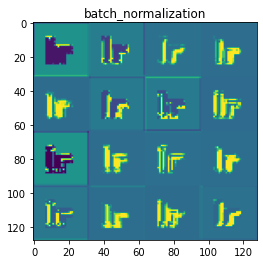

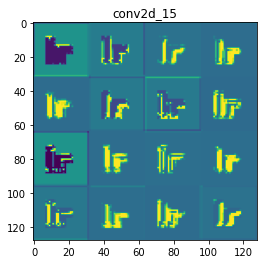

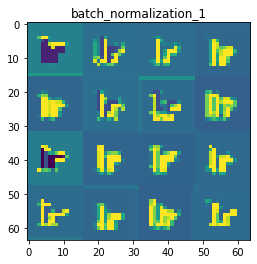

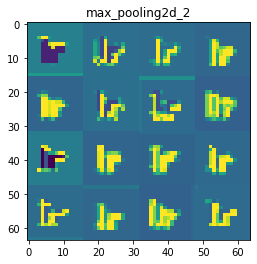

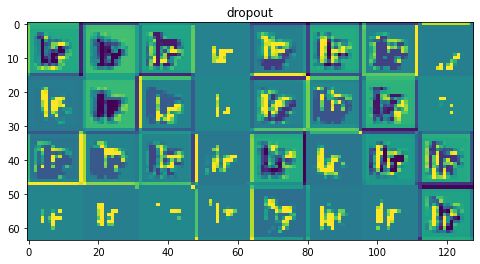

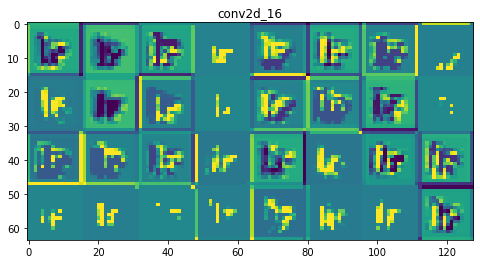

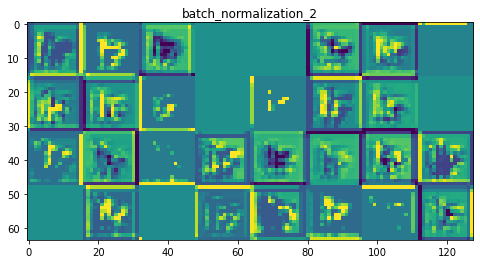

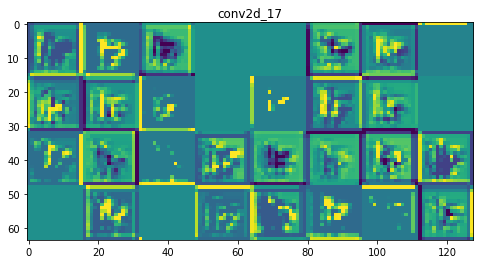

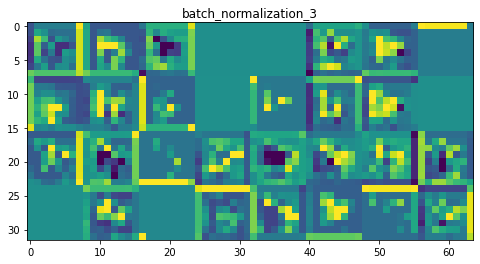

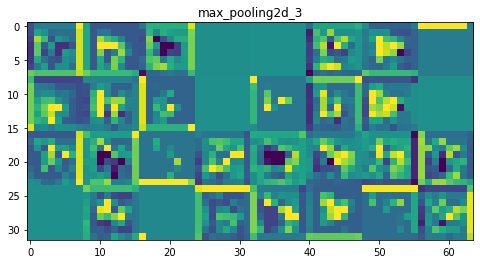

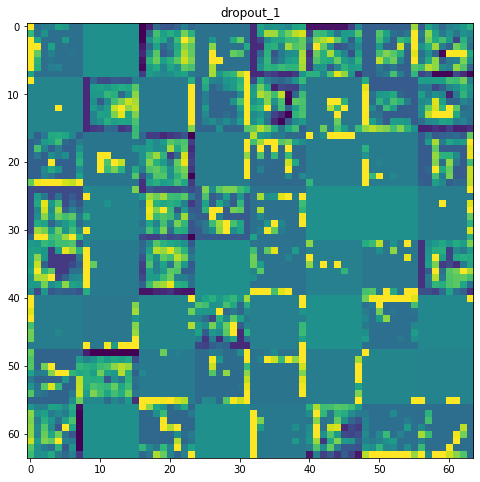

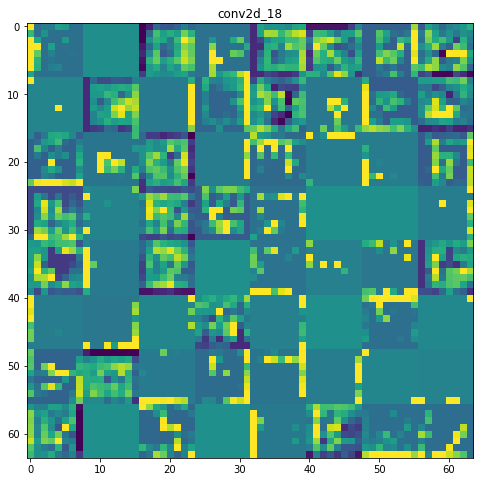

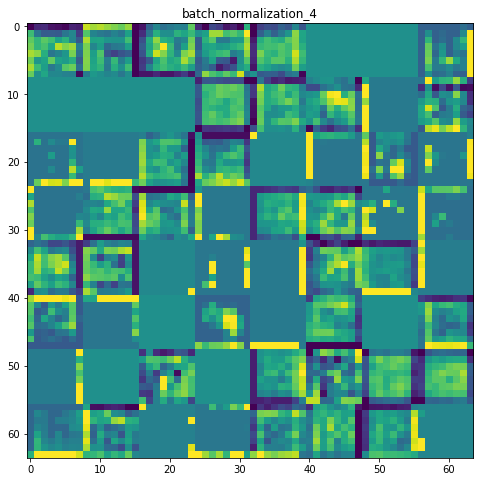

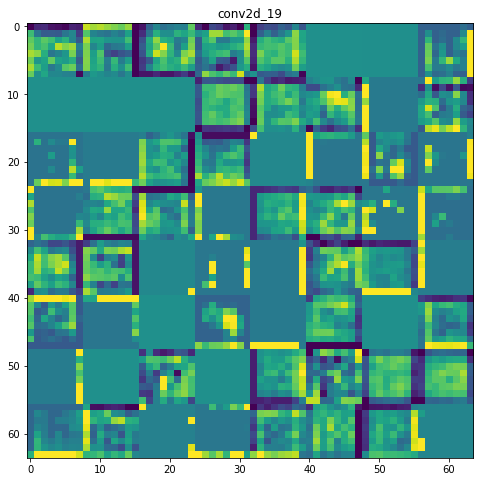

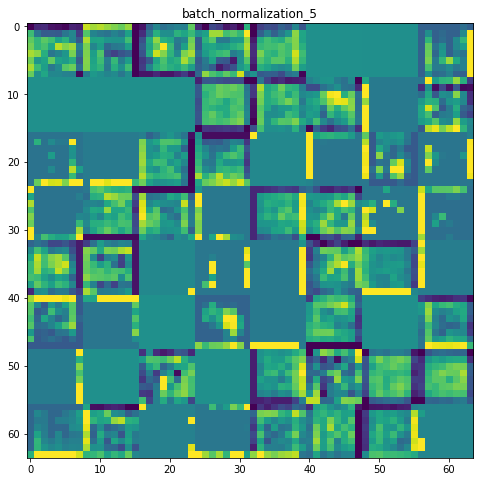

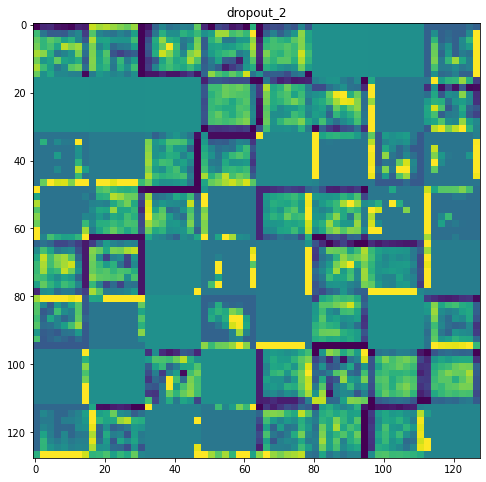

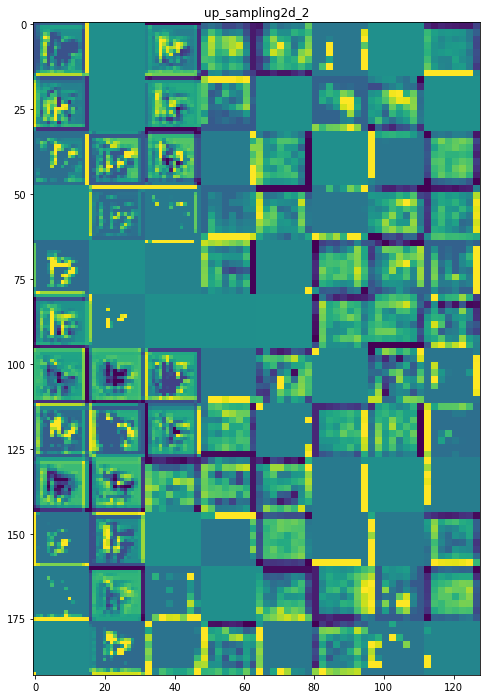

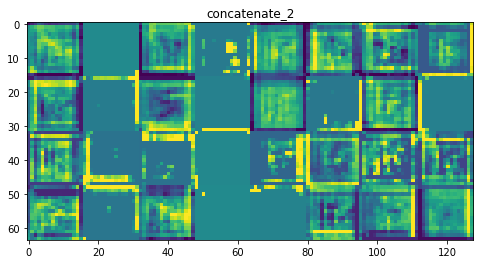

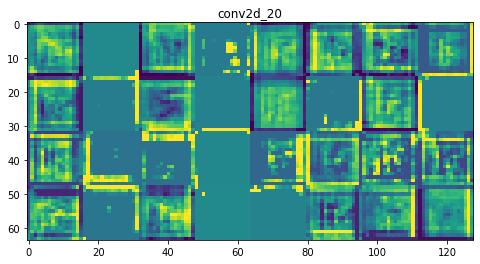

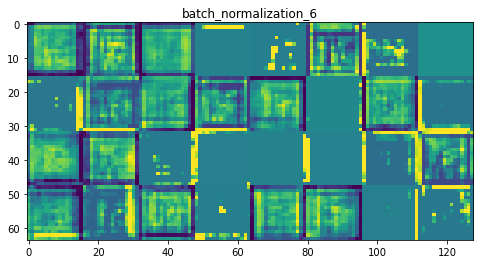

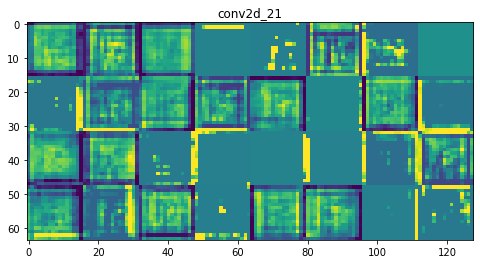

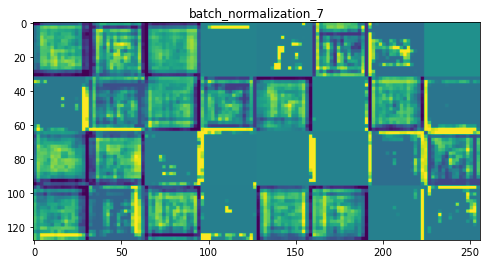

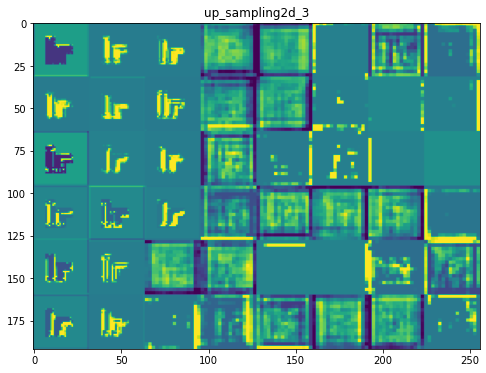

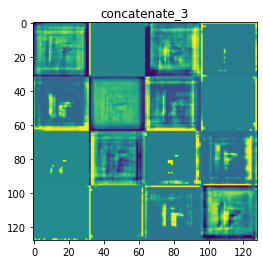

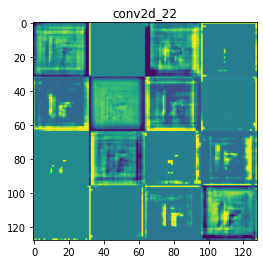

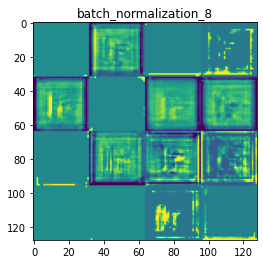

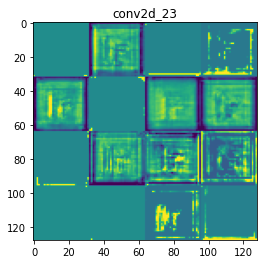

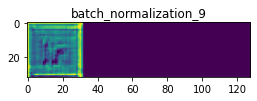

In [19]:
def display_activations(activations, model):
    for i, activation in enumerate(activations):
        # Check if the activation is 4D (batch_size, height, width, channels)
        if len(activation.shape) == 4:
            _, height, width, channels = activation.shape
            n_cols = 8 if channels > 16 else 4
            n_rows = channels // n_cols + (1 if channels % n_cols != 0 else 0)
            display_grid = np.zeros((height * n_rows, width * n_cols))

            for col in range(n_cols):
                for row in range(n_rows):
                    if col * n_rows + row < channels:
                        channel_image = activation[0, :, :, col * n_rows + row]
                        # Normalize the channel image
                        channel_image -= channel_image.mean()
                        channel_image /= channel_image.std() + 1e-5  # Avoid division by zero
                        channel_image *= 64
                        channel_image += 128
                        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                        display_grid[row * height: (row + 1) * height, col * width: (col + 1) * width] = channel_image

            scale = 1. / height
            plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
            plt.title(model.layers[i].name)  # Use the correct layer index
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='viridis')
            #plt.savefig(str(model.layers[i].name)+'.png',dpi=450)
            plt.show()

# Use one of the unet models
display_activations(activations, model_2)